# Tagret
### Author: Weiwei Ouyang
### Date: 01/07/2020

* Data Preprocess for marketing channel attribution
* Apply all marketing attribution models (first, last and markov chain)

### Load packages

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from collections import defaultdict

### Load the sample data

In [8]:
df = pd.read_csv('attribution_data_market.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [11]:
df.shape

(586737, 7)

In [12]:
df.cookie.nunique()

240108

### Data Preprocess

**Sort the visit time from start to end**

In [9]:
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])  #time from start to end

**Get visit order** So smart! Learn!

In [10]:
df['visit_order'] = df.groupby('cookie').cumcount() + 1
df.head(10)

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display,3
586730,ooooEBE0o0D97ACAAAnDoi3F0,2018-07-25T20:02:08Z,impression,0,0.0,Online Display,1
586729,ooooE0hkAFBkED90ChDDiBFAf,2018-07-03T13:36:19Z,impression,0,0.0,Online Display,1
586727,ooooAnkko0k0Dfino0oDkEoEi,2018-07-21T17:43:44Z,impression,0,0.0,Paid Search,1
586728,ooooAnkko0k0Dfino0oDkEoEi,2018-07-29T11:55:41Z,impression,0,0.0,Online Display,2


we’ll want to format the data frame from long-form to wide-form, so we’ll ultimately end up with a data frame containing a single row per user and the total chronological user-journey in a list of touch-points

**Merge all channel**

In [15]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
df_paths.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


**Get last result**

In [16]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

,cookie,conversion
586736,ooooohAFofEnonEikhAi3fF9o,0
586735,ooooiBh70D3k3BfAhDFfii9h7,0
586733,ooooEiB0CCoEf9fiiC90Dfhfk,0
586730,ooooEBE0o0D97ACAAAnDoi3F0,0
586729,ooooE0hkAFBkED90ChDDiBFAf,0


**Get first channel**

In [17]:
df_first_interaction = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel']]
df_first_interaction.head()

,cookie,channel
586736,ooooohAFofEnonEikhAi3fF9o,Paid Search
586734,ooooiBh70D3k3BfAhDFfii9h7,Paid Search
586731,ooooEiB0CCoEf9fiiC90Dfhfk,Online Display
586730,ooooEBE0o0D97ACAAAnDoi3F0,Online Display
586729,ooooE0hkAFBkED90ChDDiBFAf,Online Display


**Get the customer journey**

In [18]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths['path'] = np.where(
    df_paths['conversion'] == 0,
    ['Start'] + df_paths['channel'] + ['Null'],
    ['Start'] + df_paths['channel'] + ['Conversion'])
df_paths.head(3)

,cookie,channel,conversion,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"


In [19]:
df_paths = df_paths[['cookie', 'path']]
df_paths.head(3)

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"


### Markov Chain Analysis

**Calculate outcome features (here it is conversation)**

In [22]:
#a list of all user journeys
list_of_paths = df_paths['path']

#the total number of conversations
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())  #Smart, learn

#the base level conversion rate
base_conversion_rate = total_conversions / len(list_of_paths)  #it is a probability

In [24]:
list_of_paths[:5]

0    [Start, Instagram, Online Display, Null]
1                  [Start, Paid Search, Null]
2                  [Start, Paid Search, Null]
3                    [Start, Instagram, Null]
4                  [Start, Paid Search, Null]
Name: path, dtype: object

**How many unique channels**


In [26]:
set(x for element in list_of_paths for x in element)

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

**Generate a dictionary  for all possible transition path**

In [32]:
list_of_unique_channels = set(x for element in list_of_paths for x in element)
{x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

{'Start>Start': 0,
 'Start>Null': 0,
 'Start>Facebook': 0,
 'Start>Online Video': 0,
 'Start>Conversion': 0,
 'Start>Instagram': 0,
 'Start>Paid Search': 0,
 'Start>Online Display': 0,
 'Null>Start': 0,
 'Null>Null': 0,
 'Null>Facebook': 0,
 'Null>Online Video': 0,
 'Null>Conversion': 0,
 'Null>Instagram': 0,
 'Null>Paid Search': 0,
 'Null>Online Display': 0,
 'Facebook>Start': 0,
 'Facebook>Null': 0,
 'Facebook>Facebook': 0,
 'Facebook>Online Video': 0,
 'Facebook>Conversion': 0,
 'Facebook>Instagram': 0,
 'Facebook>Paid Search': 0,
 'Facebook>Online Display': 0,
 'Online Video>Start': 0,
 'Online Video>Null': 0,
 'Online Video>Facebook': 0,
 'Online Video>Online Video': 0,
 'Online Video>Conversion': 0,
 'Online Video>Instagram': 0,
 'Online Video>Paid Search': 0,
 'Online Video>Online Display': 0,
 'Conversion>Start': 0,
 'Conversion>Null': 0,
 'Conversion>Facebook': 0,
 'Conversion>Online Video': 0,
 'Conversion>Conversion': 0,
 'Conversion>Instagram': 0,
 'Conversion>Paid Search':

**Function that identifies all potential state transitions and outputs a dictionary**

In [29]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:  #5 channels
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s] # i is index, s is value
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

**small example of using enumerate**

In [36]:
[i for i,s in enumerate([1,3,4,5])]

[0, 1, 2, 3]

In [37]:
[s for i,s in enumerate([1,3,4,5])]

[1, 3, 4, 5]

In [30]:
trans_states = transition_states(list_of_paths)
trans_states 

{'Start>Start': 0,
 'Start>Null': 0,
 'Start>Facebook': 66848,
 'Start>Online Video': 34182,
 'Start>Conversion': 0,
 'Start>Instagram': 28618,
 'Start>Paid Search': 76210,
 'Start>Online Display': 34250,
 'Null>Start': 0,
 'Null>Null': 0,
 'Null>Facebook': 0,
 'Null>Online Video': 0,
 'Null>Conversion': 0,
 'Null>Instagram': 0,
 'Null>Paid Search': 0,
 'Null>Online Display': 0,
 'Facebook>Start': 0,
 'Facebook>Null': 59319,
 'Facebook>Facebook': 0,
 'Facebook>Online Video': 2254,
 'Facebook>Conversion': 4690,
 'Facebook>Instagram': 15252,
 'Facebook>Paid Search': 4464,
 'Facebook>Online Display': 2146,
 'Online Video>Start': 0,
 'Online Video>Null': 31285,
 'Online Video>Facebook': 2430,
 'Online Video>Online Video': 0,
 'Online Video>Conversion': 3201,
 'Online Video>Instagram': 1307,
 'Online Video>Paid Search': 1964,
 'Online Video>Online Display': 775,
 'Conversion>Start': 0,
 'Conversion>Null': 0,
 'Conversion>Facebook': 0,
 'Conversion>Online Video': 0,
 'Conversion>Conversion':

**Function to calculate all transition probabilities**

In [38]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob

In [39]:
trans_prob = transition_prob(trans_states)
trans_prob

defaultdict(dict,
            {'Start>Facebook': 0.2784080497109634,
             'Start>Online Video': 0.14236093757808985,
             'Start>Instagram': 0.11918803205224315,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Online Display': 0.14264414346877238,
             'Facebook>Null': 0.6731234042553191,
             'Facebook>Online Video': 0.025577304964539006,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Online Display': 0.02435177304964539,
             'Online Video>Null': 0.7637566525072018,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Instagram': 0.03190762169815927,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Online Display': 0.018919974610614718,
     

A Dictionary containing all transitions and their respective transition probabilities given our historical data

In [40]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [41]:
trans_matrix

,Start,Null,Facebook,Online Video,Conversion,Instagram,Paid Search,Online Display
Start,0.0,0.000000,0.278408,0.142361,0.000000,0.119188,0.317399,0.142644
Null,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Facebook,0.0,0.673123,0.000000,0.025577,0.053220,0.173072,0.050655,0.024352
Online Video,0.0,0.763757,0.059323,0.000000,0.078146,0.031908,0.047947,0.018920
Conversion,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Instagram,0.0,0.629786,0.218777,0.024118,0.057979,0.000000,0.045809,0.023531
Paid Search,0.0,0.770779,0.064442,0.029221,0.053309,0.034196,0.000000,0.048053
Online Display,0.0,0.756643,0.053986,0.017299,0.050324,0.029363,0.092386,0.000000


We can now iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from our state-space

In [51]:
#sns.set_style("whitegrid")
#fig, ax = plt.subplots(figsize=(22, 12))
#sns.heatmap(trans_matrix, cmap="YlGnBu",annot=True)
#plt.show()

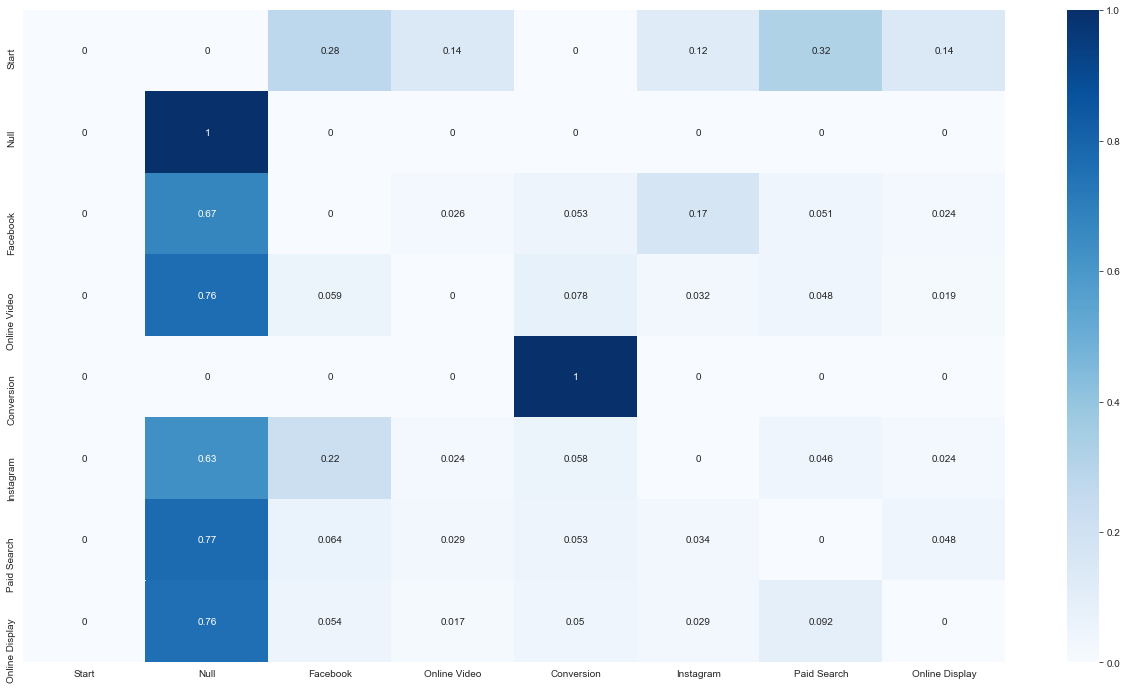

In [50]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix,cmap="Blues", annot=True)
plt.show()

**Identify removal effects for each of our marketing channels**

In [52]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [53]:
removal_effects_dict

{'Facebook': 0.3547597674182721,
 'Online Video': 0.2069141165564219,
 'Instagram': 0.21731366149038456,
 'Paid Search': 0.3311037560086154,
 'Online Display': 0.15435482356041275}

In [54]:
total_conversions

17639

In [56]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [57]:
attributions 

{'Facebook': 4948.892177847523,
 'Online Video': 2886.4480895461475,
 'Instagram': 3031.521548555893,
 'Paid Search': 4618.891257291356,
 'Online Display': 2153.2469267590823}

**Small example of zip**

In [122]:
list(zip(list(attributions.keys()),['Markov']*5,list(attributions.values())))

[('Facebook', 'Markov', 4948.892177847523),
 ('Online Video', 'Markov', 2886.4480895461475),
 ('Instagram', 'Markov', 3031.521548555893),
 ('Paid Search', 'Markov', 4618.891257291356),
 ('Online Display', 'Markov', 2153.2469267590823)]

In [125]:
markov=pd.DataFrame(list(zip(list(attributions.keys()),['Markov Chain']*5,list(attributions.values()))), columns=['Channel', 'Attribution','Conversion'])

In [126]:
markov

,Channel,Attribution,Conversion
0,Facebook,Markov Chain,4948.892178
1,Online Video,Markov Chain,2886.448090
2,Instagram,Markov Chain,3031.521549
3,Paid Search,Markov Chain,4618.891257
4,Online Display,Markov Chain,2153.246927


### First Touch and Last Touch Attribution

In [59]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


In [60]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
df_paths.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [69]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'channel','conversion']]
df_last_interaction.rename(columns={'channel':'Last_Touch'},inplace=True)
df_last_interaction.head()

,cookie,Last_Touch,conversion
586736,ooooohAFofEnonEikhAi3fF9o,Paid Search,0
586735,ooooiBh70D3k3BfAhDFfii9h7,Online Video,0
586733,ooooEiB0CCoEf9fiiC90Dfhfk,Online Display,0
586730,ooooEBE0o0D97ACAAAnDoi3F0,Online Display,0
586729,ooooE0hkAFBkED90ChDDiBFAf,Online Display,0


In [70]:
df_first_interaction = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel']]
df_first_interaction.rename(columns={'channel':'First_Touch'},inplace=True)
df_first_interaction.head()

,cookie,First_Touch
586736,ooooohAFofEnonEikhAi3fF9o,Paid Search
586734,ooooiBh70D3k3BfAhDFfii9h7,Paid Search
586731,ooooEiB0CCoEf9fiiC90Dfhfk,Online Display
586730,ooooEBE0o0D97ACAAAnDoi3F0,Online Display
586729,ooooE0hkAFBkED90ChDDiBFAf,Online Display


In [71]:
print(df_first_interaction.shape,df_last_interaction.shape)

(240108, 2) (240108, 3)


In [73]:
df_f_l_interaction=df_first_interaction.merge(df_last_interaction,how='inner')
df_f_l_interaction.shape

(240108, 4)

In [74]:
df_f_l_interaction.head(3)

,cookie,First_Touch,Last_Touch,conversion
0,ooooohAFofEnonEikhAi3fF9o,Paid Search,Paid Search,0
1,ooooiBh70D3k3BfAhDFfii9h7,Paid Search,Online Video,0
2,ooooEiB0CCoEf9fiiC90Dfhfk,Online Display,Online Display,0


In [103]:
df_ft = pd.DataFrame()
df_ft['Channel'] = df_f_l_interaction['First_Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = df_f_l_interaction['conversion']
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()
df_ft

,Channel,Attribution,Conversion
0,Facebook,First Touch,5177
1,Instagram,First Touch,2329
2,Online Display,First Touch,2160
3,Online Video,First Touch,3216
4,Paid Search,First Touch,4757


In [106]:
df_lt = pd.DataFrame()
df_lt['Channel'] = df_f_l_interaction['Last_Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = df_f_l_interaction['conversion']
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()
df_lt

,Channel,Attribution,Conversion
0,Facebook,Last Touch,5301
1,Instagram,Last Touch,2244
2,Online Display,Last Touch,2139
3,Online Video,Last Touch,3408
4,Paid Search,Last Touch,4547


### Linear Attribution

In [83]:
df_paths.head(3)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]


In [87]:
df_linear=df_paths.merge(df_f_l_interaction[['cookie','conversion']],how='inner')
df_linear.shape

(240108, 3)

In [88]:
df_linear.head(3)

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0


**Create a path variable**

In [90]:
df_linear['Path'] = ''
for i in df_linear.index:
    #df.at[i, 'Path'] = 'Start'
    for x in df_linear.at[i,'channel']:
        df_linear.at[i, 'Path'] = df_linear.at[i, 'Path'] + x + ' > '

In [93]:
df_linear.head()

,cookie,channel,conversion,Path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,Instagram > Online Display >
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,Paid Search >
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,Paid Search >
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,Instagram >
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,Paid Search >


In [100]:
channel = []
conversion = []
for i in df_linear.index:
    for j in df_linear.at[i, 'channel']:
        channel.append(j)
        conversion.append(df_linear.at[i,'conversion']/len(df_linear.at[i, 'channel']))

In [101]:
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()
lin_att_df

,Channel,Attribution,Conversion
0,Facebook,Linear,4947.600000
1,Instagram,Linear,2627.100000
2,Online Display,Linear,2143.600000
3,Online Video,Linear,3192.183333
4,Paid Search,Linear,4728.516667


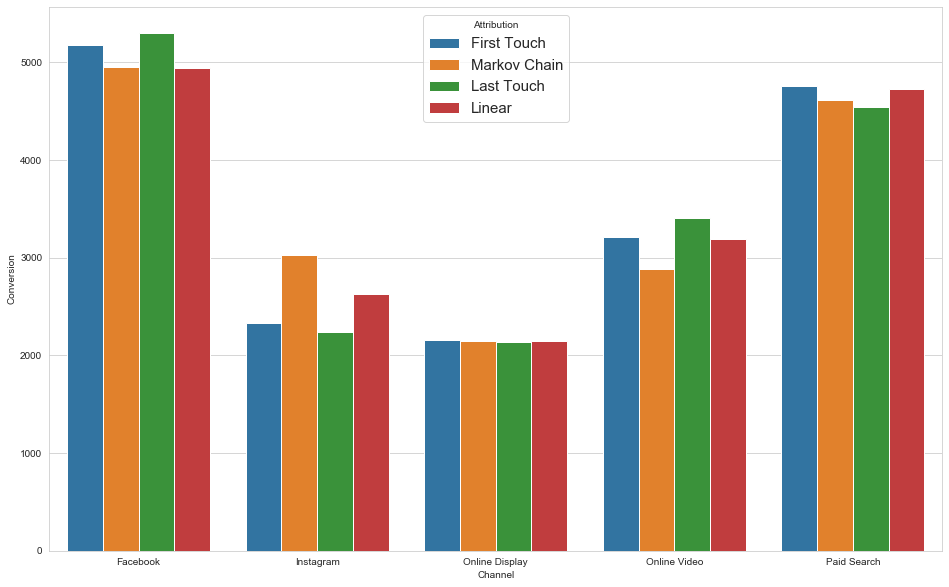

In [130]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov])
df_total_attr['Channel'] = df_total_attr['Channel']
df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)


# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()